In [29]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Simulation finished in 0:00:01.                                                 


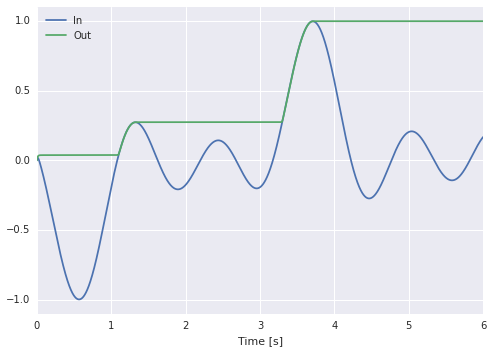

In [125]:
import nengo
import numpy as np

np.random.seed(0)


def stim(t):
    return (np.sin(-t - 1.) + np.sin(-3 * t) + np.sin(-5 * (t + 1))) / 3.

with nengo.Network() as model:
    stimulus = nengo.Node(stim)

    peak = nengo.Ensemble(1, 2, neuron_type=nengo.Direct())

    nengo.Connection(stimulus, peak[1], synapse=None)

    tau = 0.1
    dt = 0.001
    a = np.exp(-dt / tau)
    function = lambda x: ((x[1] - x[0]).clip(min=0)) / (1 - a) + x[0]
    nengo.Connection(peak, peak[0], synapse=tau, function=function)

    p_in = nengo.Probe(stimulus, synapse=0.01)
    p_out = nengo.Probe(peak[0], synapse=0.01)


with nengo.Simulator(model) as sim:
    sim.run(6)


import matplotlib.pyplot as plt

plt.figure()
plt.plot(sim.trange(), sim.data[p_in], label="In")
plt.plot(sim.trange(), sim.data[p_out], label="Out")
plt.legend(loc='best')
plt.xlabel("Time [s]")
plt.ylim(-1.1, 1.1)
plt.show()

Simulation finished in 0:00:02.                                                 


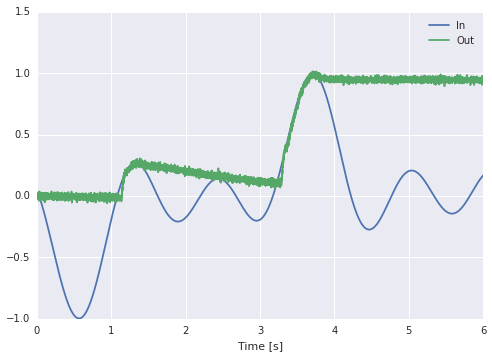

In [122]:
import nengo
import numpy as np

np.random.seed(0)


def stim(t):
    return (np.sin(-t - 1.) + np.sin(-3 * t) + np.sin(-5 * (t + 1))) / 3.

with nengo.Network() as model:
    stimulus = nengo.Node(stim)
    diff = nengo.Ensemble(
        100, 1,
        intercepts=nengo.dists.Exponential(0.15, 0., 1.),
        encoders=nengo.dists.Choice([[1]]),
        eval_points=nengo.dists.Uniform(0., 1.))
    peak = nengo.Ensemble(100, 1)
    
    tau = 0.1
    timescale = 0.01
    dt = 0.001
    nengo.Connection(stimulus, diff, synapse=tau/2)
    nengo.Connection(diff, peak, synapse=tau/2, transform=dt / timescale / (1 - np.exp(-dt / tau)))
    nengo.Connection(peak, diff, synapse=tau/2, transform=-1)
    nengo.Connection(peak, peak, synapse=tau)
    
    p_in = nengo.Probe(stimulus, synapse=0.01)
    p_out = nengo.Probe(peak, synapse=0.01)

    
with nengo.Simulator(model) as sim:
    sim.run(6)

    
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sim.trange(), sim.data[p_in], label="In")
plt.plot(sim.trange(), sim.data[p_out], label="Out")
plt.legend(loc='best')
plt.xlabel("Time [s]")
plt.show()

(array([-0.9933555,  0.       ]), array([ 0.99004983 +1.04844222e-08j,  0.99004983 -1.04844222e-08j]), 4.9667913339934699e-05)
(array([ 0.,  0.]), array([ 0.99004983,  0.99004983]), 9.9005808419194019e-05)
False


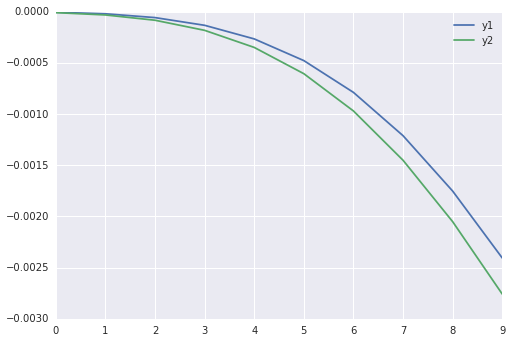

In [67]:
import nengolib
tf1 = nengolib.signal.cont2discrete(nengolib.Alpha(0.1), dt=0.001) * nengolib.signal.z

tf2 = (nengolib.signal.cont2discrete(nengolib.Lowpass(0.1), dt=0.001) *
       nengolib.signal.cont2discrete(nengolib.Lowpass(0.1), dt=0.001)) * nengolib.signal.z**2

print tf1.zpk
print tf2.zpk

print tf1 == tf2

u = nengo.processes.WhiteSignal(1.0, high=100).run(0.01, dt=0.001)

#y1 = tf1.filt(u, dt=0.001, y0=0)
#y2 = tf2.filt(u, dt=0.001, y0=0)
y1 = nengolib.signal.apply_filter(tf1, dt=None, u=u, axis=0)
y2 = nengolib.signal.apply_filter(tf2, dt=None, u=u, axis=0)

pylab.figure()
pylab.plot(y1, label="y1")
pylab.plot(y2, label="y2")
pylab.legend()
pylab.show()

In [81]:
f1 = nengolib.synapses.Highpass(0.1, order=3)
f2 = nengolib.synapses.DoubleExp(0.01, 0.05) * nengolib.signal.s**2
a1 = 0.5
a2 = 1.5
dt = 0.001

print (nengolib.signal.cont2discrete(a1*f1 + a2*f2, dt=dt) == 
       a1*nengolib.signal.cont2discrete(f1, dt=dt) + a2*nengolib.signal.cont2discrete(f2, dt=dt))

print nengolib.signal.cont2discrete(a1*f1 + a2*f2, dt=dt).tf,
print (a1*nengolib.signal.cont2discrete(f1, dt=dt) + a2*nengolib.signal.cont2discrete(f2, dt=dt)).tf


 True
(poly1d([  3000.5       , -14910.00790874,  29636.00969836, -29452.97783078,
        14635.45820428,  -2908.98216312]), poly1d([ 1.        , -4.85518559,  9.42635546, -9.14786145,  4.43739956,
       -0.86070798])) (poly1d([  3000.5       , -14910.00790874,  29636.00969836, -29452.97783078,
        14635.45820428,  -2908.98216312]), poly1d([ 1.        , -4.85518559,  9.42635546, -9.14786145,  4.43739956,
       -0.86070798]))


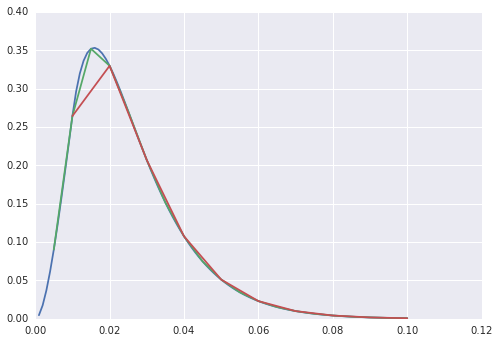

In [100]:
tf = nengolib.synapses.Alpha(0.01)

pylab.figure()
for dt in (0.001, 0.005, 0.01):
    
    u = np.zeros(int(0.1 / dt))
    u[:int(0.01/dt)] = 1.0

    t = np.arange(1, len(u) + 1)*dt
    y = tf.filt(u, dt=dt, y0=0)
    pylab.plot(t, y)
pylab.show()